In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train_set = pd.read_csv('./archive/train.csv')
test_set = pd.read_csv('./archive/test.csv')

# Adding a target variable to the testing eset
test_set['Target'] = None

# One additional we could do is to concantate the training and testing data
all_data = pd.concat((train_set, test_set), axis=0)

# Storing the predictor value
y_pred = all_data['Target']

# Storing the household leaders (there's one household leader per family)
heads = all_data.loc[all_data['parentesco1'] == 1].copy()

# Labels for training, the values we will to train the model (the predictor for the training and testing)
train_labels = all_data.loc[(all_data['Target'].notnull()) & (all_data['parentesco1'] == 1), ['Target', 'idhogar']]

In [3]:
# Shape of the training and testing set
train_set.shape, test_set.shape, all_data.shape

((9557, 143), (23856, 143), (33413, 143))

In [4]:
# More specific info on the training set
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
# More specific info on the testing set
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(129), object(6)
memory usage: 26.0+ MB


In [6]:
# Quick insight to the shape of the data
all_data.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Data Analysis: data types (dtype)

The dataset contains many potential features that could be used in our model. However, it's important to understand if they are correctly understood by Python. It's also important to visualize how the features are distributed! This can help us improve our computationally efficient.

### dtype: int64

In [7]:
def plot_nuniques_dtypes(data, d_type=np.int64):
    """Returns how many unique values for specific dtype column"""
    
    data.select_dtypes(d_type).nunique().value_counts().sort_index().plot.bar(
        color='blue', figsize=(10,6), edgecolor="k", linewidth=3)
    plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
    plt.title('Count of Unique Values in Integer Columns')

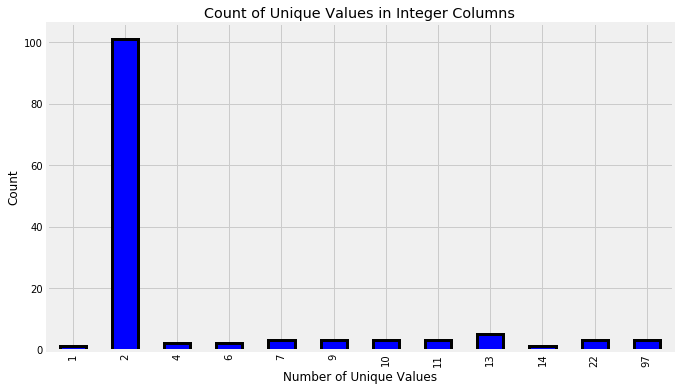

In [8]:
plot_nuniques_dtypes(train_set)

#### Notes:
- As we will notice, some features do not need to be aggregated since they are at the household level.
- However, there other features are at an individual level so we will have to aggreagate them.

### dtype: float

In [9]:
# Mapping the values of floating columns
from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

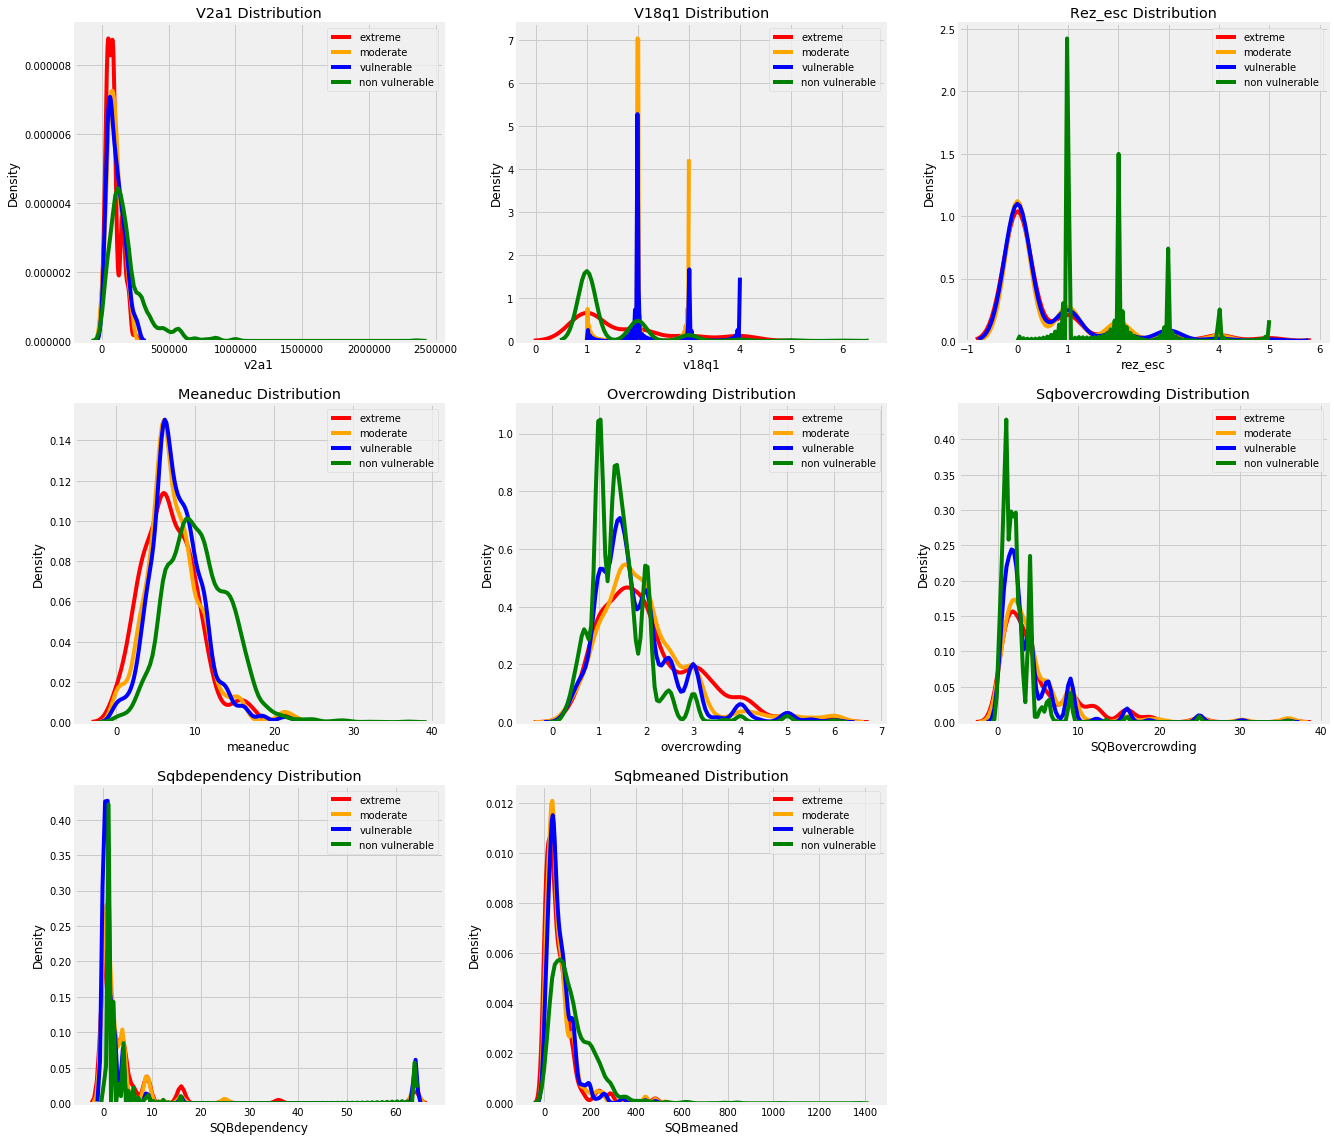

In [10]:
plt.figure(figsize=(20, 8))

# Iterate through the float columns
for i, col in enumerate(train_set.select_dtypes('float')):
    ax = plt.subplot(3, 3, i + 1)

    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top=2)

### dtype: object

In [11]:
train_set.select_dtypes('object').head(5)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


#### Notes:
- Noticed that there's a mixture of integers and strings for the 3 features: dependency, edjefe, and edjefa.
- The documenation assigns yes or no to 1 or 0 

In [12]:
# Reshaping the mixed values for object
mapping_incorrections = {'yes': 1, 'no': 0}

# Reshaping the data based on replace the yes and no
for df in [train_set, test_set, all_data]:
    for col in ['dependency', 'edjefa', 'edjefe']:
        df[col] = df[col].replace(mapping_incorrections).astype(np.float64)

In [13]:
all_data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


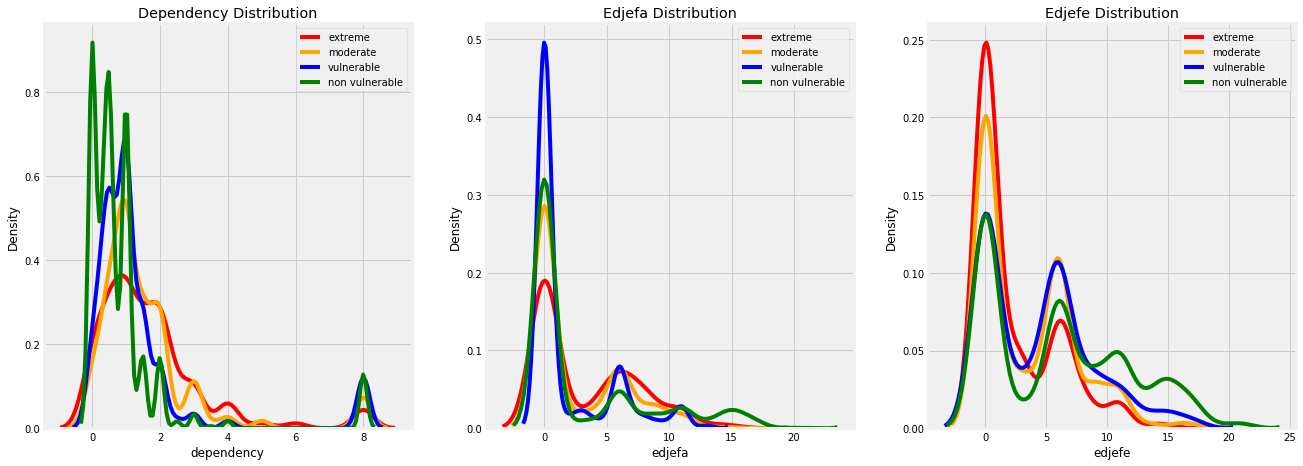

In [14]:
# Distribution across the additional floating variables

plt.figure(figsize=(20, 3))

# Iterate through floats
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(1, 3, i + 1)
    
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

#### Notes
- The distribution among the four target variables are very similar. Thus, we cannot find too much information.
- For "dependecy", non-vunerable to poverty candidates data has more noise than the other distributions.

In [15]:
# SETTING UP THE TARGET VARIABLES
TARGET_AXIS_LABELS = ('non-vunerable hh', 'moderate pov', 'vunerable hh', 'extreme pov')

Text(0.5,1,'Poverty Level')

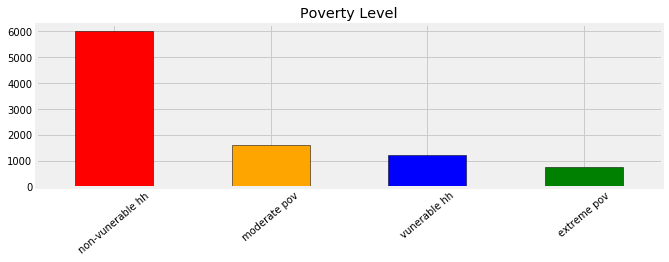

In [16]:
# Understanding the distribution of the target variable
plt_label_counts = train_set['Target'].value_counts().plot(kind="bar", figsize=(10,3), color=colors.values(),
                                                           edgecolor="k")
plt_label_counts.set_xticklabels(labels=TARGET_AXIS_LABELS, rotation=40)
plt.title("Poverty Level")


In [17]:
# Percentage of the target variable
def get_categorical_percent(data, target_label):
    """Returns the percentage of the target variables (could be any categorical column)"""
    total_sum = data[target_label].value_counts().sum()
    percents = []
    for i, target in enumerate(data[target_label].value_counts().sort_index()):
        percent = target/total_sum
        percents.append(f"Target {poverty_mapping[i+1]}: Percentage of {percent:.2f}")
        
    return percents

In [18]:
get_categorical_percent(train_set, "Target")

['Target extreme: Percentage of 0.08',
 'Target moderate: Percentage of 0.17',
 'Target vulnerable: Percentage of 0.13',
 'Target non vulnerable: Percentage of 0.63']

#### Notes
- Most of the values fall within the non-vunerable.
- Noticed that about 2/3 of the data is considered non-vunerable!

## Data Analysis: Errors

As with data collection, one process that often gets forgotten is checking if the dataset contains any error. If people are collecting the data, the potential for error is high if you ask me!

#### Notes:
- We need to have idhogars to be the same target for a household
- Unfortunately, for some families, target are not the same for the household (even with the same idhogar)
- Thus, we need to assign the target to all the member of the idhogar
- Using the head of the house's target variable

In [19]:
# Calculating the idhogar key per family... should be one unique id
trgt_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Calculating the familes that have multiple unique ids
trgt_not_equal = trgt_equal[trgt_equal == False]

# The total amnt of mismatched values
len(trgt_not_equal)

85

In [20]:
# Example of a family with different idhogar
train_set.loc[train_set["idhogar"] == trgt_not_equal.index[0], :]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
7651,ID_a5e2b0639,NaN,0,5,0,1,1,0,NaN,0,...,49,196,25,36,4,2.777778,0.444444,58.777775,196,3
7652,ID_5dfdf4ebe,NaN,0,5,0,1,1,0,NaN,0,...,100,289,25,36,4,2.777778,0.444444,58.777775,289,2
7653,ID_762e1fd96,NaN,0,5,0,1,1,0,NaN,0,...,36,2601,25,36,4,2.777778,0.444444,58.777775,2601,3
7654,ID_c76b87004,NaN,0,5,0,1,1,0,NaN,0,...,36,2304,25,36,4,2.777778,0.444444,58.777775,2304,3
7655,ID_1dffe3dcf,NaN,0,5,0,1,1,0,NaN,0,...,121,441,25,36,4,2.777778,0.444444,58.777775,441,2


In [21]:
# Potential error: the household does not have a head leader
hh_head = train_set.groupby('idhogar')['parentesco1'].sum()

# Find households without a head leader
hh_no_head = train_set.loc[train_set['idhogar'].isin(hh_head[hh_head == 0].index), :]
hh_no_head['idhogar'].nunique()

15

#### Notes:
- There are 15 households that have no head household member


In [22]:
# Potential error: there is no household leader & the family members have different target variables
hh_mistmatched = hh_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# There are no variables where we have a mismatch btw family members and no household leader
sum(hh_mistmatched == False)

0

In [23]:
# Finding the household where family memebers do not have a consistent household key
for target in trgt_not_equal.index:
    
    # Locate the true target based on the household lead key
    true_target = int(train_set[(train_set['idhogar'] == target) 
                            & (train_set['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for the target
    train_set.loc[train_set['idhogar'] == target, "Target"] = true_target
    
# Let check if all household have the same target
all_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal==False]

# Empty series - fixed the problem
not_equal

Series([], Name: Target, dtype: bool)

## Data Cleaning

There are several components that constituents data cleaning. We have to make sure that missing values are properly taken care of. Missing values should be analyzed carefully because as we will notice in the dataset, if a feature contains missing values, it might be found that it's not missing but it represents 0. Another intersting concept is that missing values could actually be represented through another feature.

In [24]:
def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing zero values
    df = df.loc[~(df==0).all(axis=1)]
    return df

def plot_value_counts(df, col, heads_only=False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (5, 5))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [25]:
# Separting the numeric and object columnac
num_cols, obj_cols = get_dtypes(all_data, verbose=False)

In [26]:
nums_missing = get_missing_values(all_data, num_cols)
nums_missing

,Missing,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077


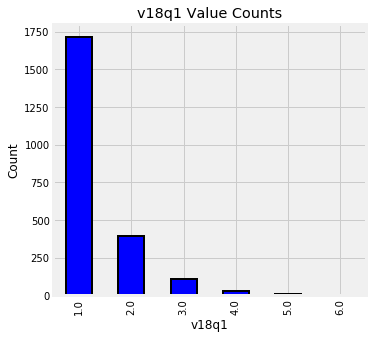

In [27]:
# Missing value: v18q1
plot_value_counts(heads, 'v18q1')

#### Notes:
- We **cannot** conclude that we should replace the missing values with 1.
- Since, the family might not own a tablet (thus, we would replace the missing data with 0)
- We need to check the binary column ('v18q') to further investigate the missing value

In [28]:
# We need to group the heads dataframe with v18q and see the null values 
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

#### Notes:
- Notice that all values that are 0 in the v18q column (binary if a person owns a tablet), for every value that v18q1 is null, it is also label as 0

In [29]:
# Filling in the missing value
all_data['v18q'] = all_data['v18q'].fillna(0)

### Missing value: `v18q1`

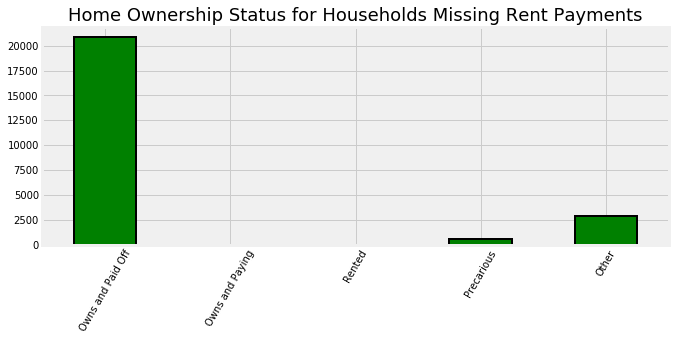

In [30]:
# v18q1 is monthly payment, thus, we should look at property ownership
ownership_cols = [x for x in all_data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
all_data.loc[all_data['v2a1'].isnull(), ownership_cols].sum().plot.bar(figsize = (10, 4),
                                                                       color = 'green',
                                                                       edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

#### Notes: 
- For the most part, we answered the problem. People who had missing payment meant that they own the property.
- However, there are still values that indicate missing values.


### Missing value: `v2a1`

In [31]:
# Updating the payment to 0 for people who own the property
all_data.loc[(all_data['v2a1'].isnull()) & (all_data['tipovivi1'] == 1), "v2a1"] = 0

# Creating an additional boolean values of people who have missing values
all_data['v2a1-missing'] = all_data['v2a1'].isnull()
all_data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [32]:
# Missing Value: rez_esc (years behind in school)

# Checking the age of people who have null values as years behind in school
all_data.loc[all_data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [33]:
# Will need to compare this with values that are not null
all_data.loc[all_data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

#### Notes:
- You cannot be "years" in school if you are not in school. 
- Thus, we can make this value 0 if you are younger than 7 or older than 19 

In [34]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
all_data.loc[((all_data['age'] > 19) | (all_data['age'] < 7)) & (all_data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
all_data['rez_esc-missing'] = all_data['rez_esc'].isnull()

# Notice that there is an outlier
print(all_data['rez_esc'].value_counts())
all_data.loc[all_data['rez_esc'] > 5, 'rez_esc'] = 5

0.0     30894
1.0       728
2.0       336
3.0       174
4.0        80
5.0        39
99.0        1
Name: rez_esc, dtype: int64


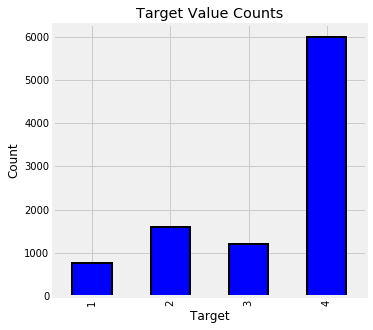

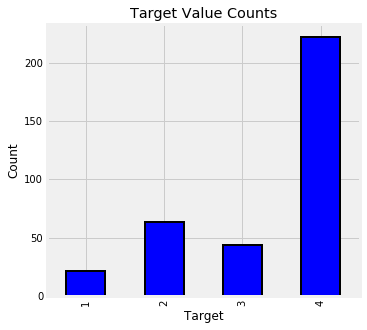

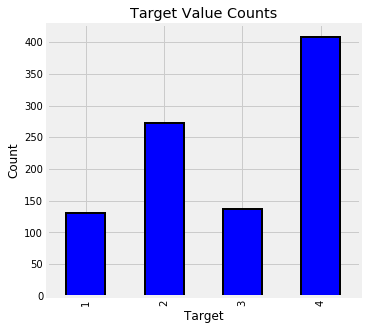

In [35]:
# Understanding how the data is related with and with not the missing values 
plot_value_counts(all_data, 'Target')
plot_value_counts(all_data[all_data['rez_esc-missing'] == 1], 'Target')
plot_value_counts(all_data[all_data['v2a1-missing'] == 1], 'Target')

#### Notes:
- Noticed that the distriution for the rez_esc_missing has a similar dist. as the data. However, the v2a1-missing has a different dist. than the data
- The missing information can be just as valuable as the data.

In [40]:
# For the feature engingerring check: Analysis_02
import pickles

# Saving the sets for future use
all_data.to_pickle("./pickles/all_data.pkl")
test_set.to_pickle("./pickles/test.pkl")